In [1]:
# Import tensorflow and additional libraries
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
#pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px

# Check version
print('torch version: ', torch.__version__)

torch version:  1.10.0+cu111


In [2]:
data_dir = './data'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



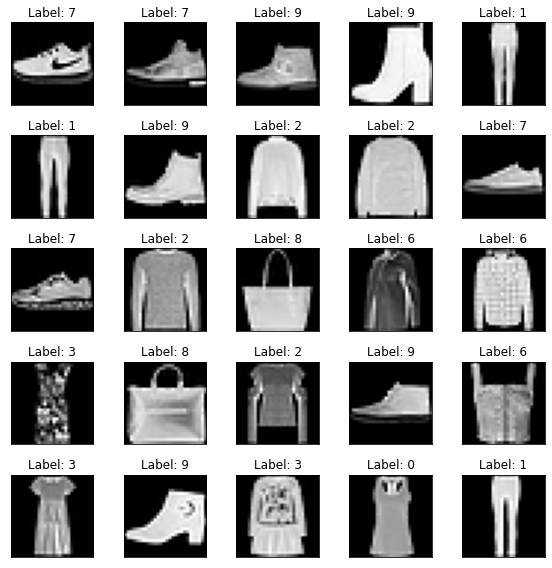

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m = len(train_dataset)

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
# train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 16

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [7]:
from torch.nn.parameter import Parameter

class channel_attention(nn.Module):    
    def __init__(self, channel, scale_factor=4):
        super(channel_attention, self).__init__()
        self.GAP = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//scale_factor, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//scale_factor, channel, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.GAP(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)

    
class spatial_attention(nn.Module):   
    def __init__(self, channel):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=3, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
    
    
class parallel_CASA_attention(nn.Module):   
    def __init__(self, channel, scale_factor):
        super(parallel_CASA_attention, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
        y = y1 + y2
    
        return x * y.expand_as(x)
    
    
def autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True)
    )
    return ae_block


def channel_autoencoder_block(input_dim, output_dim, scale_factor):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        channel_attention(output_dim, scale_factor),
        nn.ReLU(True)
    )
    return ae_block


def spatial_autoencoder_block(input_dim, output_dim):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        spatial_attention(output_dim),
        nn.ReLU(True)
    )
    return ae_block


def serial_autoencoder_block(input_dim, output_dim, scale_factor):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        channel_attention(output_dim, scale_factor),
        spatial_attention(output_dim),
        nn.ReLU(True)
    )
    return ae_block


def parallel_autoencoder_block(input_dim, output_dim, scale_factor):
    ae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        parallel_CASA_attention(output_dim, scale_factor),
        nn.ReLU(True)
    )
    return ae_block

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            autoencoder_block(1, 16),
            nn.MaxPool2d((2, 2)),
            autoencoder_block(16, 32),
            nn.MaxPool2d((2, 2)),
            autoencoder_block(32, 64)
        )
        self.decoder = nn.Sequential(
            autoencoder_block(64, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            autoencoder_block(64, 32),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            autoencoder_block(32, 16),
            nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encoder
        encoded_img = self.encoder(x)             
        
        # decoder
        decoded_img = self.decoder(encoded_img)
        
        return decoded_img

In [9]:
class Channel_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            channel_autoencoder_block(1, 16, 4),
            nn.MaxPool2d((2, 2)),
            channel_autoencoder_block(16, 32, 4),
            nn.MaxPool2d((2, 2)),
            channel_autoencoder_block(32, 64, 4)
        )
        self.decoder = nn.Sequential(
            channel_autoencoder_block(64, 64, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            channel_autoencoder_block(64, 32, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            channel_autoencoder_block(32, 16, 4),
            nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encoder
        encoded_img = self.encoder(x)             
        
        # decoder
        decoded_img = self.decoder(encoded_img)
        
        return decoded_img

In [10]:
class Spatial_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            spatial_autoencoder_block(1, 16),
            nn.MaxPool2d((2, 2)),
            spatial_autoencoder_block(16, 32),
            nn.MaxPool2d((2, 2)),
            spatial_autoencoder_block(32, 64)
        )
        self.decoder = nn.Sequential(
            spatial_autoencoder_block(64, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            spatial_autoencoder_block(64, 32),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            spatial_autoencoder_block(32, 16),
            nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encoder
        encoded_img = self.encoder(x)             
        
        # decoder
        decoded_img = self.decoder(encoded_img)
        
        return decoded_img

In [11]:
class Serial_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            serial_autoencoder_block(1, 16, 4),
            nn.MaxPool2d((2, 2)),
            serial_autoencoder_block(16, 32, 4),
            nn.MaxPool2d((2, 2)),
            serial_autoencoder_block(32, 64, 4)
        )
        self.decoder = nn.Sequential(
            serial_autoencoder_block(64, 64, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            serial_autoencoder_block(64, 32, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            serial_autoencoder_block(32, 16, 4),
            nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encoder
        encoded_img = self.encoder(x)             
        
        # decoder
        decoded_img = self.decoder(encoded_img)
        
        return decoded_img

In [12]:
class Parallel_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            parallel_autoencoder_block(1, 16, 4),
            nn.MaxPool2d((2, 2)),
            parallel_autoencoder_block(16, 32, 4),
            nn.MaxPool2d((2, 2)),
            parallel_autoencoder_block(32, 64, 4)
        )
        self.decoder = nn.Sequential(
            parallel_autoencoder_block(64, 64, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            parallel_autoencoder_block(64, 32, 4),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            parallel_autoencoder_block(32, 16, 4),
            nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # encoder
        encoded_img = self.encoder(x)             
        
        # decoder
        decoded_img = self.decoder(encoded_img)
        
        return decoded_img

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(42)

model1 = AutoEncoder()
model2 = Channel_AutoEncoder()
model3 = Spatial_AutoEncoder()
model4 = Serial_AutoEncoder()
model5 = Parallel_AutoEncoder()

In [14]:
import torchsummary
torchsummary.summary(model1, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [15]:
torchsummary.summary(model2, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 4]              64
              ReLU-5                    [-1, 4]               0
            Linear-6                   [-1, 16]              64
           Sigmoid-7                   [-1, 16]               0
 channel_attention-8           [-1, 16, 28, 28]               0
              ReLU-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           4,640
      BatchNorm2d-12           [-1, 32, 14, 14]              64
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [16]:
torchsummary.summary(model3, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3            [-1, 1, 28, 28]             144
           Sigmoid-4            [-1, 1, 28, 28]               0
 spatial_attention-5           [-1, 16, 28, 28]               0
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10            [-1, 1, 14, 14]             288
          Sigmoid-11            [-1, 1, 14, 14]               0
spatial_attention-12           [-1, 32, 14, 14]               0
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [17]:
torchsummary.summary(model4, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 4]              64
              ReLU-5                    [-1, 4]               0
            Linear-6                   [-1, 16]              64
           Sigmoid-7                   [-1, 16]               0
 channel_attention-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]             144
          Sigmoid-10            [-1, 1, 28, 28]               0
spatial_attention-11           [-1, 16, 28, 28]               0
             ReLU-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [18]:
torchsummary.summary(model5, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 4]              64
              ReLU-5                    [-1, 4]               0
            Linear-6                   [-1, 16]              64
           Sigmoid-7                   [-1, 16]               0
 channel_attention-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]             144
          Sigmoid-10            [-1, 1, 28, 28]               0
spatial_attention-11           [-1, 16, 28, 28]               0
parallel_CASA_attention-12           [-1, 16, 28, 28]               0
             ReLU-13           [-1, 16, 28, 28]               0
        MaxPool2d-14           [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [19]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# AE to the image
img_ae1 = model1(img)
img_ae2 = model2(img)
img_ae3 = model3(img)
img_ae4 = model4(img)
img_ae5 = model5(img)

print('model1 image shape:', img_ae1.shape)
print('model2 image shape:', img_ae2.shape)
print('model3 image shape:', img_ae3.shape)
print('model4 image shape:', img_ae4.shape)
print('model5 image shape:', img_ae5.shape)

Original image shape: torch.Size([1, 1, 28, 28])
model1 image shape: torch.Size([1, 1, 28, 28])
model2 image shape: torch.Size([1, 1, 28, 28])
model3 image shape: torch.Size([1, 1, 28, 28])
model4 image shape: torch.Size([1, 1, 28, 28])
model5 image shape: torch.Size([1, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [21]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001
#lr = 0.0008 # Learning rate

optim1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-05)
optim2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=1e-05)
optim3 = torch.optim.Adam(model3.parameters(), lr=lr, weight_decay=1e-05)
optim4 = torch.optim.Adam(model4.parameters(), lr=lr, weight_decay=1e-05)
optim5 = torch.optim.Adam(model5.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move both the encoder and the decoder to the selected device
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)
model4 = model4.to(device)
model5 = model5.to(device)

In [22]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Decode data
        decoded_data = model(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [23]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Decode data
            decoded_data = model(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [24]:
def plot_ae_outputs(model, n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img = model(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

In [25]:
num_epochs = 20
history1 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model1, device, train_loader, loss_fn, optim1)
    val_loss = test_epoch(model1, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history1['train_loss'].append(train_loss)
    history1['val_loss'].append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



 EPOCH 1/20 	 train loss 0.008 	 val loss 0.005

 EPOCH 2/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 5/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 6/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 7/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 9/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 10/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 11/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [26]:
num_epochs = 20
history2 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model2, device, train_loader, loss_fn, optim2)
    val_loss = test_epoch(model2, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history2['train_loss'].append(train_loss)
    history2['val_loss'].append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



 EPOCH 1/20 	 train loss 0.008 	 val loss 0.005

 EPOCH 2/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 5/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 6/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 7/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 8/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 9/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 10/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 11/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.005

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.004


In [27]:
num_epochs = 20
history3 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model3, device, train_loader, loss_fn, optim3)
    val_loss = test_epoch(model3, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history3['train_loss'].append(train_loss)
    history3['val_loss'].append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



 EPOCH 1/20 	 train loss 0.009 	 val loss 0.005

 EPOCH 2/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 3/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 5/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 6/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 7/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 9/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 10/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 11/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [28]:
num_epochs = 20
history4 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model4, device, train_loader, loss_fn, optim4)
    val_loss = test_epoch(model4, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history4['train_loss'].append(train_loss)
    history4['val_loss'].append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



 EPOCH 1/20 	 train loss 0.009 	 val loss 0.005

 EPOCH 2/20 	 train loss 0.005 	 val loss 0.004

 EPOCH 3/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 5/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 6/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 7/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 8/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 9/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 10/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 11/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


In [29]:
num_epochs = 20
history5 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model5, device, train_loader, loss_fn, optim5)
    val_loss = test_epoch(model5, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history5['train_loss'].append(train_loss)
    history5['val_loss'].append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



 EPOCH 1/20 	 train loss 0.018 	 val loss 0.009

 EPOCH 2/20 	 train loss 0.006 	 val loss 0.005

 EPOCH 3/20 	 train loss 0.005 	 val loss 0.005

 EPOCH 4/20 	 train loss 0.004 	 val loss 0.004

 EPOCH 5/20 	 train loss 0.004 	 val loss 0.003

 EPOCH 6/20 	 train loss 0.004 	 val loss 0.003

 EPOCH 7/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 8/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 9/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 10/20 	 train loss 0.003 	 val loss 0.004

 EPOCH 11/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 12/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 13/20 	 train loss 0.003 	 val loss 0.007

 EPOCH 14/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 15/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 16/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 17/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 18/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 19/20 	 train loss 0.003 	 val loss 0.003

 EPOCH 20/20 	 train loss 0.003 	 val loss 0.003


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 1152x720 with 0 Axes>

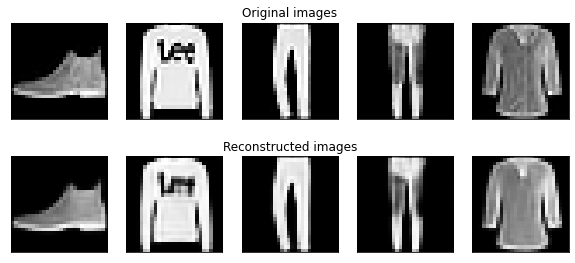

In [30]:
# Vanilla AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model1, n=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 1152x720 with 0 Axes>

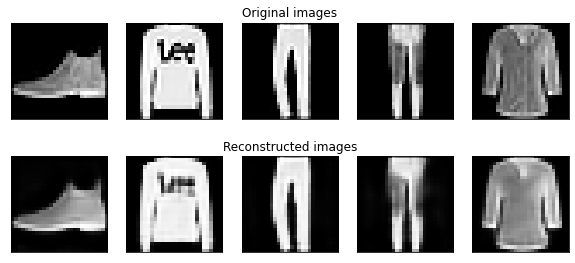

In [31]:
# Channel AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model2, n=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 1152x720 with 0 Axes>

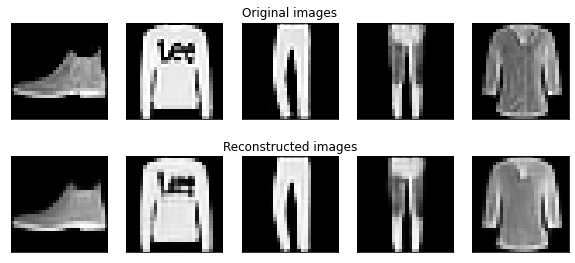

In [32]:
# Spatial AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model3, n=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 1152x720 with 0 Axes>

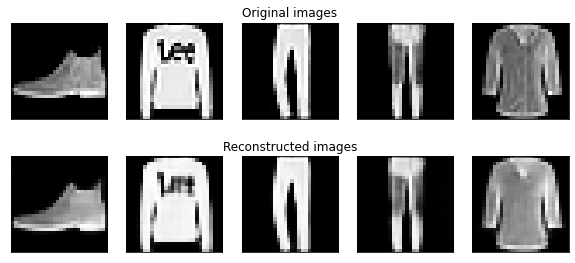

In [33]:
# Serial AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model4, n=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 1152x720 with 0 Axes>

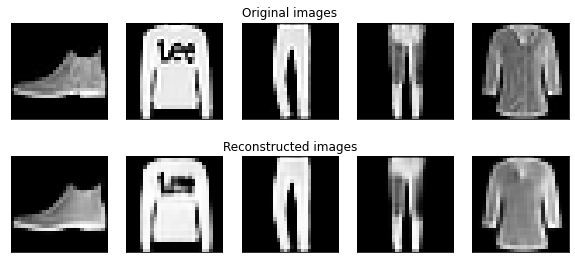

In [34]:
# Parallel AE
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model5, n=5)

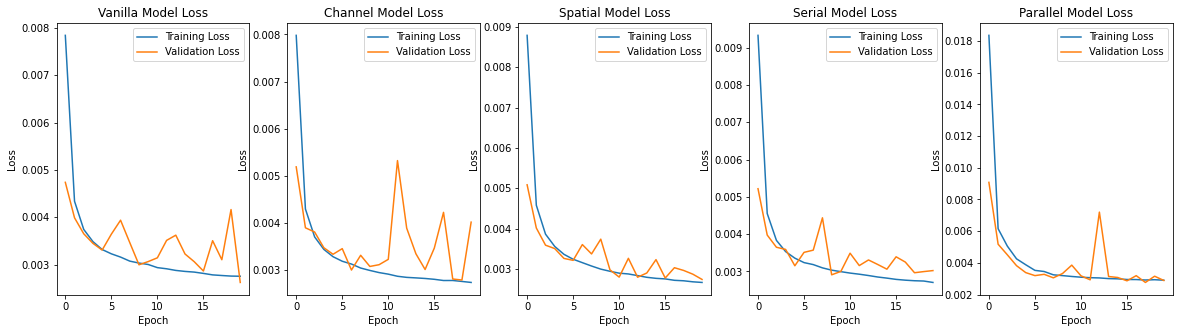

In [36]:
plt.figure(figsize=(20, 5))

plt.subplot(1,5,1)
plt.plot(history1['train_loss'])
plt.plot(history1['val_loss'])
plt.title('Vanilla Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(1,5,2)
plt.plot(history2['train_loss'])
plt.plot(history2['val_loss'])
plt.title('Channel Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(1,5,3)
plt.plot(history3['train_loss'])
plt.plot(history3['val_loss'])
plt.title('Spatial Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(1,5,4)
plt.plot(history4['train_loss'])
plt.plot(history4['val_loss'])
plt.title('Serial Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(1,5,5)
plt.plot(history5['train_loss'])
plt.plot(history5['val_loss'])
plt.title('Parallel Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()